## This notebook is for plotting CVs of trajectories and visualization with chemiscope

In [9]:
import chemiscope
import torch 
import numpy as np
import os
from typing import Dict, List, Optional
from scipy.stats import moment
from metatensor.torch import Labels, TensorBlock, TensorMap
from metatomic.torch import (
    AtomisticModel,
    ModelCapabilities,
    ModelEvaluationOptions,
    ModelMetadata,
    ModelOutput,
    System,
    systems_to_torch,
    load_atomistic_model
)
from featomic.torch import SoapPowerSpectrum
import vesin
from ase.io import read
import matplotlib.pyplot as plt

In [17]:
cwd = '/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/metad/test'
model_name = "/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/soap_wrapper_zmin25.0_zmax35.0.pt"
#model_name = '/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/results/amorph-metad-1ps/v0/SOAP/866/all/PCAfull/interval_1/lag_0/sigma_0/ridge_a1e-05/SOAP_866_[8]/model_soap.pt'
trj_name = 'positions.lammpstrj'

In [18]:
# Load model
CVmodel = load_atomistic_model(os.path.join(cwd, model_name), extensions_directory='.')


[W209 22:43:44.324746000 model.cpp:868] Warning: failed to load extension dependency gomp-e985bcbb.so.1.0.0. We tried the following:
 - ./featomic_torch.libs/libgomp-e985bcbb.so.1.0.0
 - loading gomp-e985bcbb.so.1.0.0 directly by name
You can set `METATENSOR_DEBUG_EXTENSIONS_LOADING=1` in your environemnt for more information
 (function load_library)
[W209 22:43:44.325331000 model.cpp:959] Warning: Current torch version (2.8.0) is not compatible with the version (2.7.1+cu126) used to export the model at '/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/soap_wrapper_zmin25.0_zmax35.0.pt'; proceed at your own risk. (function check_atomistic_model)


#### Load trajectory for testing

In [14]:
structures = read('/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/metad/positions.lammpstrj', index=':')
structures = structures[::10]

# Adjust trj:

In [20]:
systems = systems_to_torch(structures, dtype=torch.float64)

systems_new = []
for i, system in enumerate(systems):
    
    #atoms = structures[i]
    nlistoptions = CVmodel.requested_neighbor_lists()[0]
    print(nlistoptions)
    nlist = vesin.NeighborList(cutoff=nlistoptions.cutoff, full_list=nlistoptions.full_list) 
    i, j, S, D = nlist.compute(
        points=system.positions,
        box=system.cell, 
        periodic=True,
        quantities="ijSD"
    )
    #i, j, S, D = ase_neighbor_list(quantities="ijSD", a=atoms, cutoff=4.5)
    i = torch.from_numpy(i.astype(int))
    j = torch.from_numpy(j.astype(int))
    neighbor_indices = torch.stack([i, j], dim=1)
    neighbor_shifts = torch.from_numpy(S.astype(int))

    sample_values = torch.hstack([neighbor_indices, neighbor_shifts])
    samples = Labels(
        names=[
            "first_atom",
            "second_atom",
            "cell_shift_a",
            "cell_shift_b",
            "cell_shift_c",
        ],
        values=sample_values,
    )

    neighbors = TensorBlock(
        values=torch.from_numpy(D).reshape(-1, 3, 1),
        samples=samples,
        components=[Labels.range("xyz", 3)],
        properties=Labels.range("distance", 1),
    )
    system.add_neighbor_list(nlistoptions, neighbors)
    systems_new.append(system)
systems = systems_new

NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=6.000000, full_list=F

#### Get CV values

In [21]:
selected_atoms = Labels(
        names=["system", "atom"],
        values=torch.tensor([[0, j] for j in np.arange(0, len(structures[0]), 3)], dtype=torch.int32),)
    

eval_options = ModelEvaluationOptions(
            length_unit='',
            outputs={"features": ModelOutput(per_atom=False), 
                     "features/per_atom": ModelOutput(per_atom=True)},
            selected_atoms=selected_atoms,
        )
CVs = []
CVs_per_atom = []
sel_atoms = []
for system in systems:
    cv = CVmodel(
        systems=[system],
        options=eval_options,
        check_consistency=True,
    )
    CVs.append(cv['features'].block().values)
    CVs_per_atom.append(cv['features/per_atom'].block().values)
    sel_atoms.append(cv['features/per_atom'].block().samples.values)

newselatoms [156, 2]
newselatoms [156, 2]
newselatoms [153, 2]
newselatoms [156, 2]
newselatoms [157, 2]
newselatoms [153, 2]
newselatoms [149, 2]
newselatoms [154, 2]
newselatoms [153, 2]
newselatoms [152, 2]
newselatoms [154, 2]
newselatoms [153, 2]
newselatoms [150, 2]
newselatoms [154, 2]
newselatoms [153, 2]
newselatoms [152, 2]
newselatoms [155, 2]
newselatoms [152, 2]
newselatoms [152, 2]
newselatoms [154, 2]
newselatoms [154, 2]
newselatoms [154, 2]
newselatoms [155, 2]
newselatoms [157, 2]
newselatoms [155, 2]
newselatoms [157, 2]
newselatoms [156, 2]
newselatoms [158, 2]
newselatoms [155, 2]
newselatoms [159, 2]
newselatoms [156, 2]
newselatoms [154, 2]
newselatoms [151, 2]
newselatoms [153, 2]
newselatoms [153, 2]
newselatoms [155, 2]
newselatoms [152, 2]
newselatoms [155, 2]
newselatoms [151, 2]
newselatoms [152, 2]
newselatoms [152, 2]
newselatoms [154, 2]
newselatoms [153, 2]
newselatoms [152, 2]
newselatoms [148, 2]
newselatoms [150, 2]
newselatoms [151, 2]
newselatoms [

In [26]:
sel_atoms[0][:,1]

tensor([   9,   12,   15,   21,   24,   39,   42,   45,  105,  108,  111,  117,
         120,  135,  138,  141,  195,  198,  204,  210,  213,  219,  222,  225,
         228,  240,  243,  246,  249,  252,  258,  267,  270,  273,  297,  300,
         303,  309,  312,  327,  330,  333,  354,  630,  660,  723,  735,  741,
         744,  747,  750,  753,  873,  876,  879,  885,  888,  903,  906,  909,
         930, 1017, 1020, 1023, 1029, 1032, 1047, 1050, 1053, 1068, 1152, 1155,
        1161, 1164, 1170, 1176, 1179, 1185, 1296, 1299, 1302, 1305, 1314, 1320,
        1323, 1326, 1329, 1338, 1341, 1353, 1356, 1359, 1365, 1368, 1383, 1386,
        1389, 1440, 1443, 1446, 1449, 1458, 1467, 1470, 1473, 1536, 1539, 1548,
        1554, 1563, 1569, 1662, 1731, 1734, 1746, 1755, 1758, 1761, 1770, 1827,
        1854, 1857, 1920, 1923, 1926, 1929, 1935, 1938, 1944, 1947, 1950, 1953,
        1977, 1980, 1983, 1989, 1992, 2007, 2010, 2013, 2025, 2028, 2031, 2037,
        2040, 2055, 2058, 2061, 2073, 20

In [41]:
CVs_per_atom[1][:,0]

tensor([-0.2217, -0.6000, -0.4487, -0.1350,  0.4510,  0.7105,  1.2172, -0.1219,
        -0.0951, -0.3693, -0.8113,  0.6802, -0.5359,  1.2362,  1.4901, -0.2548,
         1.3347,  1.0389,  1.2474,  0.9309,  1.0099,  1.4049,  0.6504,  1.2983,
         0.7866,  0.6695,  0.5656,  1.5512,  0.5775,  0.5109,  0.6331,  1.3911,
         0.9534,  0.7805, -0.6850, -0.3855, -0.4553, -0.4775, -0.3351, -0.1546,
        -0.3758, -0.1946,  0.7504,  0.5126,  0.6471,  0.1177,  0.8359,  1.0247,
         1.2563,  0.9745,  0.8101,  0.2356,  0.9297,  0.8602,  0.3327, -0.3813,
        -0.1206, -0.2611,  0.1862,  0.4725,  1.2729,  0.4840,  0.8209, -0.2727,
        -0.1224, -0.3684, -0.3716,  0.8972,  0.9367,  1.2183,  0.2358,  0.8961,
         1.3925,  0.7559, -0.0099,  1.3572,  0.5270,  0.8586,  0.8959,  1.1202,
         0.3309,  1.5052,  0.4333,  0.0040,  1.1341,  1.0334,  0.3541,  0.4430,
         0.9623, -0.7520, -0.3472,  0.0965, -0.8731,  0.7467, -0.3066, -0.1398,
         1.5351,  1.2710,  0.7548,  0.81

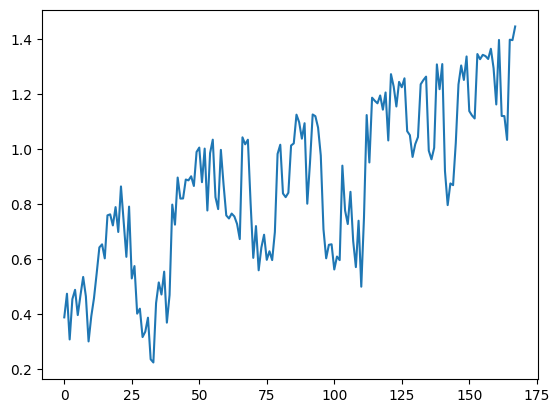

In [42]:
CVperatom = [Cpa[:,0].numpy() for Cpa in CVs_per_atom]
#torch.stack(CVs_per_atom, dim=0).squeeze().numpy()
CV = [C[:,0].numpy() for C in CVs]
#CV = torch.stack(CVs, dim=0).squeeze().numpy()
plt.plot(CV)



In [43]:
io = structures[0].get_atomic_numbers() == 8
ins = [np.where(np.isin(frame.symbols, ["O"]))[0] for frame in structures] #O indices

time=[]
#for atoms in traj:
#    time.append(atoms.info['timestep'])
time = np.arange(0, len(structures))*1.0  # 1ps interval

envs = []
for j in range(len(structures)):
    for i in ins[0]:
        envs.append((j, i, 3.5))

cs = chemiscope.show(
    structures, 
    properties={
        'time': time,
        'o_cv': {"values": CVperatom, "target": "atom"},
        'cv': {"values": CV, "target": "structure"},},
    mode="structure",
    settings=chemiscope.quick_settings(trajectory=True, structure_settings={"unitCell":True,
             'environments': {'activated': True}, 'map': {'color': {'property': 'o_cv'}}, 'color': {'property': 'o_cv', 'min': -0.1,
                              'max': 0.1, 'transform': 'linear','palette': 'bwr'} }),
    environments=envs, #[(j,i,3.5) for j in range(len(structures)) for i in io]
)


properties = {
        'time': time,
        'cv_peratom': {"values": np.hstack(CVperatom), "target": "atom"},
        'cv': {"values": CV, "target": "structure"},
}

settings = chemiscope.quick_settings(trajectory=True, structure_settings={
    "unitCell":True,
    'environments': {'activated': True}, 
    'map': {'color': {'property': 'cv_peratom'}}, 
    'color': {'property': 'cv_peratom', 
              'min': -0.1, 
              'max': 0.1, 
              'transform': 'linear',
              'palette': 'bwr',
        } 
    }
)

chemiscope.write_input(
    path="trajectory-waterice-CV.json.gz",
    # dataset metadata can also be included to provide a self-contained description
    # of the data, authors, and references
    metadata={
        "name": "SOAP CV trj",
        "description": (
            "CV per atom for a water-ice trajectory"
        ),
        "authors": ["Markus Fasching, Hannah Tuerk"],
    },
    structures=structures,
    properties=properties,
    environments=envs,
    settings=settings,
)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (168,) + inhomogeneous part.

In [5]:
chemiscope.show_input("trajectory-waterice-CV.json.gz")
    

<ChemiscopeWidget(meta={'name': 'SOAP CV trj', 'description': 'CV per atom for a water-...}, settings={'map': …

In [1]:
ins = [np.where(np.isin(frame.symbols, ["O"]))[0] for frame in structures] #O indices

values = CVperatom

values = [i for val in values for i in val]
print(np.max(values))
envs = []
for j in range(len(structures)):
    for i in ins[j]:
        envs.append((j, i, 3.5))

cs2 = chemiscope.show(
    structures, 
    properties={
        'time': time,
        "cv_peratom": {"values": values, "target": "atom"},
        'cv': {"values": CV, "target": "structure"},
    },
    #mode="structure",
    settings=chemiscope.quick_settings(trajectory=True, structure_settings={"unitCell":True,
             'environments': {'activated': False}, 'color': {'property': 'cv_peratom', 'min': -1,
                              'max': 1, 'transform': 'linear','palette': 'bwr'} }),
    environments=envs,
)
#cs2

NameError: name 'structures' is not defined

In [55]:
cs2

<ChemiscopeWidget(meta={'name': ' '}, settings={'map': {'joinPoints': True}, 'structure': [{'keepOrientation':…